# Neural Network for Sentiment Analysis

## Experimenting with word embeddings

In [2]:
import numpy as np 
import pandas as pd
from bs4 import BeautifulSoup
import string
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import time
import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from itertools import product
# scipy.special for the sigmoid function expit()
import scipy.special
# library for plotting arrays
import matplotlib.pyplot
# ensure the plots are inside this notebook, not an external window
%matplotlib inline

## Text Preprocessing

In [3]:
def get_wordnet_pos(tag):
    """Take a POS tag and return the corresponding WordNet POS tag.

    Parameter:
    -tag: a POS tag.
    """
    
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN  # Default to noun if the POS is not recognized

In [4]:
def preprocess_text(text,remove_digits=True):
    """Read a csv file and clean the text by removing html string using the BeautifulSoup library.
    Apply tokenization and lemmatization.
    Return the df with the preprocessed text in the respective column.
    
    Parameters:
    -reviews_file: path to a csv file containing the final reviews, provided as a Python string.
    -text_column: name of the column in the csv file where the reviews are stored, provided as a Python string.
    """
    
    #removing HTML tags using BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    #removing square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    #removing special characters
    if remove_digits:
        text = re.sub('[^a-zA-Z\s]', '', text)
    else:
        text = re.sub('[^a-zA-Z0-9\s]', '', text)
    
    #lowercasing the text
    text = text.lower()

    #tokenization with NLTK
    tokens = nltk.word_tokenize(text)

    #removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    #lemmatization with POS tagging
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(tokens) #applying the NLTK POS tags to tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos_tag)) for token, pos_tag in pos_tags] #lemmatizing each token based on its POS
    lemmatized_text = ' '.join(lemmatized_tokens)  #joining lemmatized tokens back into a single string

    return lemmatized_text

###part of the code as seen on https://www.kaggle.com/code/aashidutt3/sentiment-analysis-sephora-reviews/notebook on Jan 23rd

In [5]:
output_file_path = './sephora-data/sa-reviews_smaller.csv'
text_column = 'text'

# reading the csv file into a DataFrame with pandas
df = pd.read_csv(output_file_path)
# applying the preprocessing function to the text column
df[text_column] = df[text_column].apply(preprocess_text)

/var/folders/c3/6b53cyc56hdcsrh90312r_1w0000gn/T/ipykernel_9959/1671045480.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
/var/folders/c3/6b53cyc56hdcsrh90312r_1w0000gn/T/ipykernel_9959/1671045480.py:12: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


## Splitting Data into Train and Test

In [6]:
def plot_sentence_length_histogram(data, bins=30):
    """
    Plot a histogram of sentence lengths in words for the given dataset.
    Return the pandas Series containing the lengths of words in sentences.

    Parameters:
    - data: list or series of text reviews in the dataset, as a pandas df format.
    - bins: number of bins for the histogram, the default is set to 30. The higher the number, the more detailed view of the distribution.
    """
    
    pd_histogram = pd.Series([len(review.split()) for review in data])
    
    # plotting the histogram
    fig, ax = matplotlib.pyplot.subplots()
    sns.histplot(pd_histogram, bins=bins, ax=ax)
    ax.set_xlabel("Sentences length")
    
    # displaying summary statistics
    print(pd_histogram.describe())
    
    return pd_histogram
    
### code for plotting sentence length as seen at https://www.kaggle.com/code/themeeemul/sephora-eda-and-sentiment-analysis-using-pytorch/notebook on 30th Jan 2024

In [7]:
# Split data into training and test sets
reviews_tr, reviews_test, gold_labels_tr, gold_labels_test = train_test_split(df['text'], # the text column with all the reviews in the df
                                                                                    df['label'], # the labels for all the data
                                                                                    test_size = 0.20 # we use 80% for training and 20% for test
                                                                                   )

# Split data into training and dev sets
reviews_train, reviews_dev, gold_labels_train, gold_labels_dev = train_test_split(reviews_tr, # the text column with the reviews in the reduced df resulting from the split above
                                                                                    gold_labels_tr, # the labels for training data resulting from the split above
                                                                                    test_size = 0.20 # we use 80% for training and 20% for development
                                                                                   )

In [8]:
print("Training texts:", len(reviews_train))
print("Training labels:", len(gold_labels_train))
print("Test texts:", len(reviews_test))
print("Test labels:", len(gold_labels_test))
print("Development texts:", len(reviews_dev))
print("Development labels:", len(gold_labels_dev))

Training texts: 31939
Training labels: 31939
Test texts: 9981
Test labels: 9981
Development texts: 7985
Development labels: 7985


count    31939.000000
mean        29.292151
std         20.602007
min          0.000000
25%         16.000000
50%         24.000000
75%         37.000000
max        200.000000
dtype: float64
0    19
1    55
2    37
3    74
4    19
dtype: int64


/Users/arianabritez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


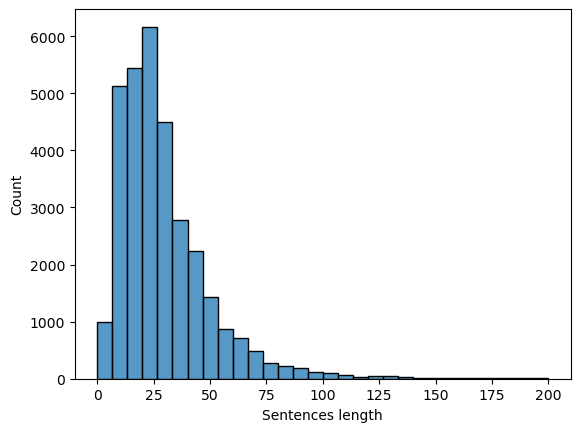

In [9]:
#checking the average length in words in the reviews text under training split
pd_histogram = plot_sentence_length_histogram(reviews_train)
print(pd_histogram.head())

## NN input preprocessing

In [10]:
def read_word_embbedding(file_name):
    """Read a GloVe txt file containing pre-trained word embeddings with 6B tokens and 50 dimensions.
    Return the Python set of unique words and the word-to-vector Python dictionary.

    Parameters:
    -'file_name': the path to the txt file storing the GloVe pre-trained embeddings."""
    
    with open(file_name,'r') as f:
        word_vocab = set() # not using list to avoid duplicate entry
        word2vector = {}
        for line in f:
            line = line.strip() #removing white spaces
            words_vec = line.split() #spliting the line into a list of word and vectors.
            word_vocab.add(words_vec[0]) #adding the first element of words_vec (the word) to the word_vocab set.
            word2vector[words_vec[0]] = np.array(words_vec[1:],dtype=float) #making a np array from the vector components of words_vec which is the value of the word in the word2vector dictionary
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

### code as seen in https://www.kaggle.com/code/adepvenugopal/nlp-word-embedding-using-glove-vector on Jan 30th

In [11]:
def training_data_to_word_index_sequences(reviews_train, min_df=300):
    """
    Tokenize and preprocess training text data using CountVectorizer and applying padding.
    Return the padded sequence vectors for the training data and a dictionary mapping words to indices.
    
    Parameters:
    - reviews_train: list of training sentences.
    - min_df: minimum frequency of a token to be considered, default set to 300.
    """
    X_train_sequences = [] #empty list where the sequences of word indices per sentence will be stored
    
    #tokenization with CountVectorizer,  if a token appears fewer times than stated, it will be ignored
    vectorizer = CountVectorizer(min_df=min_df)

    #fit and transform the training data
    X_train_counts = vectorizer.fit_transform(reviews_train)

    #getting the vocabulary and creating a mapping of words to indices
    vocab = vectorizer.vocabulary_
    word_to_index = {word: index for index, word in enumerate(vocab.keys())}

    #converting sentences to sequences for training data
    for sentence in reviews_train:
        word_indices = [word_to_index[word] for word in nltk.word_tokenize(sentence) if word in word_to_index] #tokenizing each sentence in the training data into sequences of word indices
        X_train_sequences.append(word_indices) #append the sequence of word indices for a sentence to the sequence list

    return X_train_sequences, word_to_index

In [31]:
def dev_test_data_to_word_index_sequences(reviews_dev_test, word_to_index):
    """
    Tokenize and preprocess dev/test data using precomputed word-to-index mapping.
    Return the padded sequence vectors for the dev/test data.
    
    Parameters:
    - reviews_dev_test: list of dev/test sentences.
    - word_to_index: a dictionary mapping words to indices.
    """
    X_dev_test_sequences = [] #empty list where the sequences of word indices per sentence will be stored
    
    #converting sentences to sequences for dev/test data
    for sentence in reviews_dev_test:
        word_indices = [word_to_index[word] for word in nltk.word_tokenize(sentence) if word in word_to_index] #tokenizing each sentence in the data into sequences of word indices
        X_dev_test_sequences.append(word_indices) #append the sequence of word indices for a sentence to the sequence list

    return X_dev_test_sequences
    

In [13]:
def initialize_embedding_matrix(word_to_index, w2v, embedding_dim=50):
    """
    Initialize an embedding matrix with pre-trained embeddings.
    Return a 2-dimensional numpy array representing the embedding matrix.

    Parameters:
    - word_to_index: a dictionary mapping words to their indices in the vocabulary.
    - w2v: a dictionary of pre-trained word embeddings.
    - embedding_dim: the dimension of the word embeddings.
    """
    
    #initializing embedding matrix with zeros- - each row corresponds to a word in the vocabulary
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim))

    #filling embedding matrix with pre-trained embeddings
    #if a word in the vocabulary is present in the pre-trained embeddings, its embedding is used; otherwise, the corresponding row remains filled with zeros
    for word, index in word_to_index.items():
        if word in w2v:
            embedding_matrix[index] = w2v[word]

    return embedding_matrix

In [14]:
def embed_and_pad_sequences(sequences, embedding_matrix, max_len):
    """
    Embed and pad sequences using a pre-trained embedding matrix.
    Return a 2-dimensional numpy array representing the embedded and padded sequences with the shape: number of sequences, max_len * embedding dimension
    
    Parameters:
    - sequences: a list of sequences, where each sequence is a list of word indices.
    - embedding_matrix: a 2D numpy array representing the pre-trained word embedding matrix.
    - max_len: the maximum length of the vector to pad sequences.
    """
    
    #initializing an empty list to store padded and embedded sequences
    padded_embedded_sequences = []

    #iterating over each sequence
    for sequence in sequences:
        #initializing an empty list to store embeddings for each word in the sequence
        embedded_sequence = []
        
        #iterating over each word index in the sequence
        for word_index in sequence:
            #getting the pre-trained embedding from the embedding matrix
            embedding_vector = embedding_matrix[word_index]
            #appending the embedding vector for each word to the embedded sequence
            embedded_sequence.append(embedding_vector)

        #padding the embedded sequence to the length fixed in max_len
        padded_sequence = embedded_sequence + [np.zeros(embedding_matrix.shape[1])] * (max_len - len(embedded_sequence))

        #appending the padded and embedded sequence to the list of padded sequences
        padded_embedded_sequences.append(padded_sequence)

    #converting the list of padded and embedded sequences to a numpy array
    embedded_array = np.array([seq[:max_len] for seq in padded_embedded_sequences])

    #reshaping the 3D array (with the rows of the size of the data, the length of padded vector and the dimensions of the word embeddings) to a 2D array
    #resulting in a vector of shape: (rows of the size of the data, length of padded vector * the dimensions of the word embeddings)
    #in final vector each row corresponds to a sequence of word embeddings, and the columns represent the flattened embedding vectors for each word in the sequence
    embedded_flat_array = embedded_array.reshape((embedded_array.shape[0], -1))
    
    return embedded_flat_array

In [15]:
#reading and loading the word embedding vector with 50 dimensions
vocab, w2v = read_word_embbedding("./glove6b50dtxt/glove.6B.50d.txt")

Total Words in DataSet: 400000


In [16]:
#preprocessing to pad sequences in both training and dev data
max_len=35
X_train_seq, word_to_index = training_data_to_word_index_sequences(reviews_train)
X_dev_seq = dev_test_data_to_word_index_sequences(reviews_dev,word_to_index)
embedding_matrix = initialize_embedding_matrix(word_to_index, w2v)
X_train_embedded = embed_and_pad_sequences(X_train_seq, embedding_matrix, max_len)
X_dev_embedded = embed_and_pad_sequences(X_dev_seq, embedding_matrix, max_len)

## Building the Neural Network

In [17]:
# neural network class definition
class neuralNetwork:
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        #set the number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to nodej in the next layer
        # w11 w21
        # w12 w22 etc
        #self.wih = (numpy.random.rand(self.hnodes, self.inodes) - 0.5) ##random initialization
        #self.who = (numpy.random.rand(self.onodes, self.hnodes) - 0.5)
        self.wih = np.random.normal(0.0, pow(self.hnodes, -0.5),(self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5),(self.onodes, self.hnodes))
        
        #learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)

        pass
        
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        #calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.who.T, output_errors)

        # update the weights for the links between the hidden and output layers
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))

        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
        
        pass
        
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T                                
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs


In [18]:
# number of input, hidden and output nodes
input_nodes = X_train_embedded.shape[1] #this is the size of the features - the length of the embedded padded vector
hidden_nodes = 300
output_nodes = 30

# learning rate
learning_rate = 0.15

# create instance of neural network
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

## Training the NN

In [19]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

###code taken from https://www.kaggle.com/code/themeeemul/sephora-eda-and-sentiment-analysis-using-pytorch/notebook on 26th Jan - useful to print how long the epochs take

In [20]:
def min_max_scale(embedding_vector, min_val=0.01, max_val=1.0):
    """Calculate the minimum and maximum values in the input vector and scale each embedding to fit the specified range. 
    Return a scaled embeding vector.
    
    Parameters:
    -embedding_vector: a 2-dimensional numpy array representing the embedded and padded sequences in the data with the shape: number of sequences, max_len * embedding dimension.
    -min_val: float specifying the minimum value of the scaled range, default value is 0.01.
    -max_val: float specifying the maximum value of the scaled range, default value is 1.0.
    """

    #getting the minimum and maximum values in the vector
    min_embedding = np.min(embedding_vector) 
    max_embedding = np.max(embedding_vector)

    #scaling each element of the input vector using the min-max scaling formula
    scaled_embedding = min_val + (max_val - min_val) * (embedding_vector - min_embedding) / (max_embedding - min_embedding)

    return scaled_embedding

In [21]:
def train_nn(nn, reviews_train, gold_labels_train, epochs):
    """
    Train a neural network with the provided training dataset and gold labels.
    Return None.

    Parameters:
    - nn: an instance of the neural network class
    - reviews_train: the training dataset (features)
    - gold_labels_train: the training gold labels
    - epochs: number of times the training data set is ran for training
    """
    
    output_nodes = nn.onodes  #number of output nodes in the nn

    scaled_embedding = min_max_scale(reviews_train)
    
    for epoch in range(epochs):
        # Measure how long the training epoch takes.
        t0 = time.time()
        
        #iterating over each training instance
        for array, (index, value) in zip(scaled_embedding, gold_labels_train.items()):
            inputs = array

            # creating the target output values (all 0.01, except the desired label which is 0.99)
            targets = np.zeros(output_nodes) + 0.01
            #the value of the label is the target label for this record
            targets[int(value)] = 0.99

            #training the neural network
            nn.train(inputs, targets)
            
        # Measure elapsed time for the epoch.
        elapsed_time = time.time() - t0

        # Print the epoch training time.
        print(f"Epoch {epoch + 1}/{epochs}, Elapsed Time: {format_time(elapsed_time)}")

In [22]:
def test_nn(nn, data_test, g_labels_test):
    """
    Test a neural network with the test or development data for validation.
    Return the classification report with the error metrics and print the confusion matrix.

    Parameters:
    - nn: an instance of the neural network class
    - data_test: the test or dev dataset (features)
    - g_labels_test: the test or dev labels

    Print classification report with error metrics: precision, recall, F1 and accuracy.
    Plot the confusion matrix.
    """
    
    labels = ['0','1']
    human_labels_test = []
    system_labels_pred = []

    scaled_embedding = min_max_scale(data_test)
    
    # go through all the records in the test/dev data set
    for array, (index, value) in zip(scaled_embedding, g_labels_test.items()):
        inputs = array
        # correct answer is the first value
        correct_label = int(value)
        human_labels_test.append(str(correct_label))

        # query the network
        outputs = nn.query(inputs)
        # the index of the highest value corresponds to the predicted label
        predicted_label = np.argmax(outputs)

        # append correct or incorrect to the scorecard
        if predicted_label == correct_label:
            # network's answer matches correct answer, add 1 to scorecard
            system_labels_pred.append('1')
        else:
            # network's answer doesn't match correct answer, add 0 to scorecard
            system_labels_pred.append('0')

    report = classification_report(human_labels_test, system_labels_pred, digits = 2, target_names = labels)
    cf_matrix = confusion_matrix(human_labels_test, system_labels_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
    print(report)
    print(cf_matrix)
    display.plot()

In [22]:
#max_count = X_train_embedded_flat.max()
train_nn(n, X_train_embedded, gold_labels_train, epochs=5)

Epoch 1/5, Elapsed Time: 0:01:05
Epoch 2/5, Elapsed Time: 0:01:24
Epoch 3/5, Elapsed Time: 0:01:29
Epoch 4/5, Elapsed Time: 0:01:16
Epoch 5/5, Elapsed Time: 0:01:17


              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3998
           1       0.95      0.99      0.97      3987

    accuracy                           0.97      7985
   macro avg       0.97      0.97      0.97      7985
weighted avg       0.97      0.97      0.97      7985

[[3781  217]
 [  20 3967]]


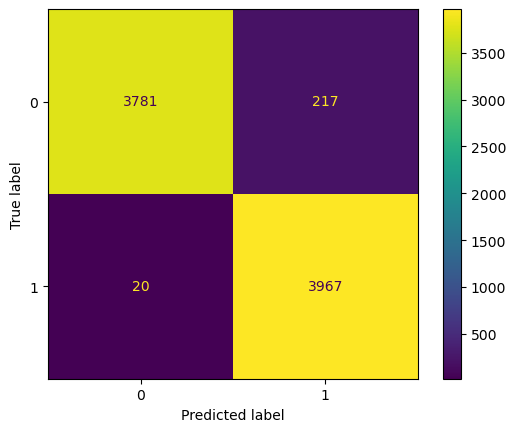

In [23]:
test_nn(n, X_dev_embedded, gold_labels_dev)

## Evaluation on test dataset

In [28]:
#preprocessing to pad sequences in test data
max_len=35
X_test_seq = dev_test_data_to_word_index_sequences(reviews_test,word_to_index)
X_test_embedded = embed_and_pad_sequences(X_test_seq, embedding_matrix, max_len)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      5029
           1       0.94      0.99      0.97      4952

    accuracy                           0.97      9981
   macro avg       0.97      0.97      0.97      9981
weighted avg       0.97      0.97      0.97      9981

[[4740  289]
 [  29 4923]]


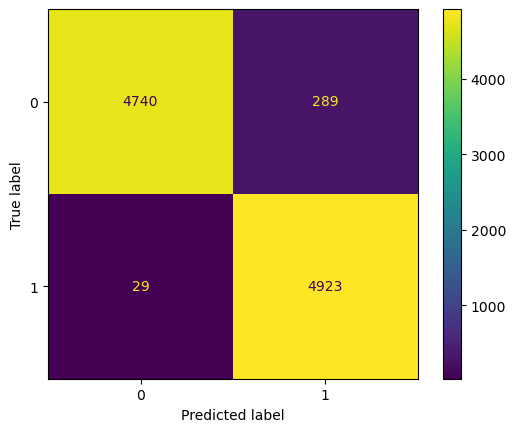

In [29]:
test_nn(n, X_test_embedded, gold_labels_test)